<a href="https://colab.research.google.com/github/jacobalmon/CS-478/blob/main/Yet_another_copy_of_CS_478_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Mounting Google Drive.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Task 1: Data Preparation
# Load the CIFAR-10 Dataset.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize Pixel Values to [0 , 1].
x_train = x_train.astype("float32") / 255.0
x_test= x_test.astype("float32") / 255.0

In [ ]:
# Task 2: Model Design.
# Load EfficientNetB0 with Pretrained ImageNet Weights w/o Top Classification.
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze Pretrained Layers.
base_model.trainable = False

# Build Model.
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce to a Single Vector.
    layers.BatchNormalization(),
    layers.Dense(126, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),  # L2 Regularization
    layers.Dropout(0.3),  # Prevent Overfitting.
    layers.Dense(10, activation='softmax')  # CIFAR-10 Output (10 Classes Total).
])

# Compile  Model.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of Model.
model.summary()

# Testing. (Delete Later)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1, 1, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 126)                 │         161,406 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 126)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,270 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,217,367 (16.09 MB)

 Trainable params: 165,236 (645.45 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
# Task 3: Training.
# Data Augmentation
data_gen = ImageDataGenerator(
    width_shift_range=0.05,    # Smaller range
    height_shift_range=0.05,   # Smaller range
    horizontal_flip=True,
    rotation_range=15,         # Adding rotation for more diversity
    zoom_range=0.1,            # Zooming for variability
    shear_range=0.1            # Shearing for robustness
)

# Initialize Epochs & Batch Size
epochs_init = 5  # Increased to 10 for better convergence
epoch_finetune = 15
batch_size = 64

# Training Custom Classification Layer
history_init = model.fit(
    data_gen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    epochs=epochs_init,
    verbose=1
)

# Unfreeze Layers & Fine Tune Model
base_model.trainable = True

# Compile Model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping & ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train for Additional 15 Epochs
history_finetune = model.fit(
    data_gen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    epochs=epoch_finetune,
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 78s 70ms/step - accuracy: 0.1076 - loss: 2.4595 - val_accuracy: 0.1000 - val_loss: 2.3235
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 43ms/step - accuracy: 0.1146 - loss: 2.3152 - val_accuracy: 0.1040 - val_loss: 2.3177
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.1222 - loss: 2.3042 - val_accuracy: 0.1058 - val_loss: 2.3077
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.1281 - loss: 2.2975 - val_accuracy: 0.1152 - val_loss: 2.2950
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.1239 - loss: 2.2911 - val_accuracy: 0.1231 - val_loss: 2.2931
Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 155s 105ms/step - accuracy: 0.2123 - loss: 2.1243 - val_accuracy: 0.0732 - val_loss: 2.7265 - learning_rate: 1.0000e-04
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.4433 - loss: 1.5682 - val_accuracy: 0.1529 - val_loss: 4.0377 - learning_rate: 1.0000e-04
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━

In [ ]:
# Save the Model.
model.save('/content/drive/MyDrive/cs478_model_hw3.keras')

In [ ]:
# Load the Model
model = load_model('/content/drive/MyDrive/cs478_model_hw3.keras')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6410 - loss: 1.1039
Test Accuracy: 0.6355999708175659


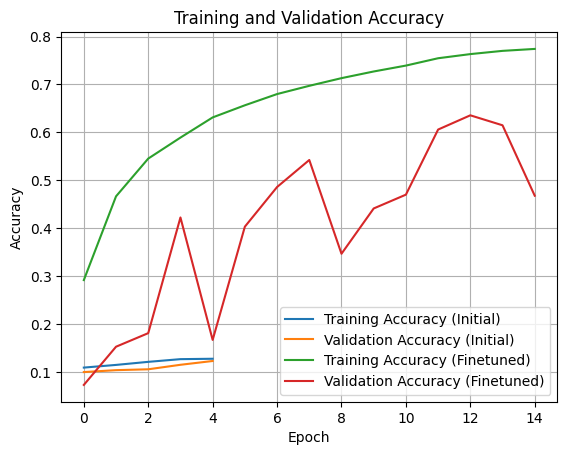

In [15]:
# Evaluating the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Plot Training & Validation Accuracy for both phases
plt.plot(history_init.history['accuracy'], label='Training Accuracy (Initial)')
plt.plot(history_init.history['val_accuracy'], label='Validation Accuracy (Initial)')
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy (Finetuned)')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy (Finetuned)')

# Adding labels and title to the plot
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Displaying the legend and the plot
plt.legend()
plt.grid(True)
plt.show()